# 1. Load Libaries

In [1]:
import pandas as pd
import time
from datetime import datetime

# Data Visualization
import matplotlib.pyplot as plt

# 2. Load Data

In [ ]:
train = pd.read_csv('./Data/train_v2.csv')
members = pd.read_csv('./Data/members_v3.csv')
transactions = pd.read_csv('./Data/transactions_v2.csv')
user_logs = pd.read_csv('./Data/user_logs_v2.csv')

# 3. Exploring File Structure and Cleaning Data

## Train Data

The train set contains user ids and whether they have churned in March 2017. 
* is_churn = 1 means churn
* is_churn = 0 means renewal

In [3]:
train = pd.read_csv('./Data/train_v2.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970960 entries, 0 to 970959
Data columns (total 2 columns):
msno        970960 non-null object
is_churn    970960 non-null int64
dtypes: int64(1), object(1)
memory usage: 14.8+ MB


In [3]:
train.describe()

,is_churn
count,970960.000000
mean,0.089942
std,0.286099
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


The train set contains churn information for 970,960 users. Fortunately, there are no missing values in this dataset, so there is nothing to clean. 

It is interesting to note that a majority of the users have renewed their subscription (is_churn = 0); only 8.9% have churned. 

## Members Data

The members dataset contains user information. 
* msno
* city
* bd: age
* gender
* registered_via: registration method
* registration_init_time: format %Y%m%d

In [5]:
members = pd.read_csv('./Data/members_v3.csv')
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6769473 entries, 0 to 6769472
Data columns (total 6 columns):
msno                      object
city                      int64
bd                        int64
gender                    object
registered_via            int64
registration_init_time    int64
dtypes: int64(4), object(2)
memory usage: 309.9+ MB


The dataset provides user information for 6769473 user which is an abundance compared to the information we have in the train dataset. We will filter down the dataset to only those in the train data.

In [8]:
members = members[members.msno.isin(train.msno.tolist())]
members.reset_index(drop=True, inplace=True)
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860967 entries, 0 to 860966
Data columns (total 6 columns):
msno                      860967 non-null object
city                      860967 non-null int64
bd                        860967 non-null int64
gender                    388905 non-null object
registered_via            860967 non-null int64
registration_init_time    860967 non-null int64
dtypes: int64(4), object(2)
memory usage: 39.4+ MB


Now we've cut down the data to 860967 which is the relevant data. 

There are a few of the columns are in the wrong data type. 
* **registration_init_time** (the date the user registered on) should be a datetime object
* **city** (represented by integers) should be a categorical variable
* **gender** (Male or Female) should be a categorical variable
* **registration_via** (represented by integers) should be a categorical variable

In [9]:
members['registration_init_time'] = members.registration_init_time.apply(lambda x: datetime.strptime(str(x), "%Y%m%d").date() if pd.notnull(x) else None)
members['city'] = members.city.astype('category')
members['gender'] = members.gender.astype('category')
members['registered_via'] = members.registered_via.astype('category')

In [7]:
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6769473 entries, 0 to 6769472
Data columns (total 6 columns):
msno                      object
city                      category
bd                        int64
gender                    category
registered_via            category
registration_init_time    object
dtypes: category(3), int64(1), object(2)
memory usage: 174.3+ MB


count    6.769473e+06
mean     9.795794e+00
std      1.792590e+01
min     -7.168000e+03
25%      0.000000e+00
50%      0.000000e+00
75%      2.100000e+01
max      2.016000e+03
Name: bd, dtype: float64


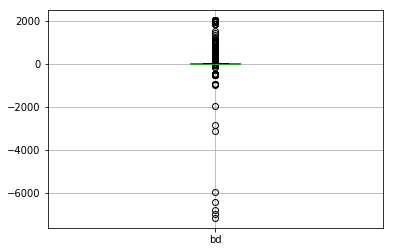

In [8]:
print(members.bd.describe())
members.boxplot(column = 'bd')
plt.show()

According to the table, the data contains members who are -3152 years old while the max age is 2016. This doesn't make sense. You can also visually see that there are a lot of outliers.

To make sure these data points do not skew the data, we will cap the age range from 1 - 100 and treat 0 as missing data.

In [10]:
members['bd'] = members.bd.apply(lambda x: int(x) if x in range(1,101) else None)

In [72]:
members.describe()

,bd
count,386715.000000
mean,29.904216
std,8.920391
min,1.000000
25%,24.000000
50%,28.000000
75%,34.000000
max,100.000000


Removing those outliers cut out more than half, but it's better to only keep data that make sense.

## Transactions data

The transactions dataset describes the monetary transactions users have made on their accounts. 
* msno: user id
* payment_method_id: payment method
* payment_plan_days: length of membership plan in days
* plan_list_price: in New Taiwan Dollar (NTD)
* actual_amount_paid: in New Taiwan Dollar (NTD)
* is_auto_renew
* transaction_date: format %Y%m%d
* membership_expire_date: format %Y%m%d
* is_cancel: whether or not the user canceled the membership in this transaction

In [11]:
transactions = pd.read_csv('./Data/transactions_v2.csv')
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1431009 entries, 0 to 1431008
Data columns (total 9 columns):
msno                      1431009 non-null object
payment_method_id         1431009 non-null int64
payment_plan_days         1431009 non-null int64
plan_list_price           1431009 non-null int64
actual_amount_paid        1431009 non-null int64
is_auto_renew             1431009 non-null int64
transaction_date          1431009 non-null int64
membership_expire_date    1431009 non-null int64
is_cancel                 1431009 non-null int64
dtypes: int64(8), object(1)
memory usage: 98.3+ MB


In [11]:
len(set(transactions.msno))

1197050

Although the dataset has 1431009 entries, it seems that a user can make multiple transactions, meaning that the dataset contains transactional data for 1197050 users. However, we only need those in the train data.

In [12]:
transactions = transactions[transactions.msno.isin(train.msno.tolist())]
transactions.reset_index(drop=True, inplace=True)
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132036 entries, 0 to 1132035
Data columns (total 9 columns):
msno                      1132036 non-null object
payment_method_id         1132036 non-null int64
payment_plan_days         1132036 non-null int64
plan_list_price           1132036 non-null int64
actual_amount_paid        1132036 non-null int64
is_auto_renew             1132036 non-null int64
transaction_date          1132036 non-null int64
membership_expire_date    1132036 non-null int64
is_cancel                 1132036 non-null int64
dtypes: int64(8), object(1)
memory usage: 77.7+ MB


Again, a few columns are in the wrong data type:
* **payment_method_id** (represented by integers) should be a categorical variable
* **is_auto_renew** should be a categorical variable
* **transaction_date** should be datetime object
* **member_expire_date** should be datetime object
* **is_cancel** should be a categorical variable

In [13]:
from datetime import datetime
cat = ['payment_method_id', 'is_auto_renew', 'is_cancel']
for col in cat:
    transactions[col] = transactions[col].astype('category')

transactions['transaction_date'] = transactions['transaction_date'].apply(lambda x: datetime.strptime(str(x), "%Y%m%d").date() if pd.notnull(x) else None)
transactions['membership_expire_date'] = transactions['membership_expire_date'].apply(lambda x: datetime.strptime(str(x), "%Y%m%d").date() if pd.notnull(x) else None)

In [24]:
transactions.describe()

,payment_plan_days,plan_list_price,actual_amount_paid
count,1.132036e+06,1.132036e+06,1.132036e+06
mean,3.356030e+01,1.455336e+02,1.450239e+02
std,3.179832e+01,1.331882e+02,1.333376e+02
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000e+01,9.900000e+01,9.900000e+01
50%,3.000000e+01,1.490000e+02,1.490000e+02
75%,3.000000e+01,1.490000e+02,1.490000e+02
max,4.500000e+02,2.000000e+03,2.000000e+03


There does not seem to be any missing data. However, the fact that the minimum value for all 3 columns is 0 is worth investigating into since the data might use 0 as placeholders for missing data. 

In [18]:
transactions[transactions.payment_plan_days == 0].head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
285,0bAK8hFztHoYGFNDktYu66rw4KWeOnvcnlLxsuXSXSw=,41,0,0,149,1,2015-04-26,2017-06-24,1
1168,8NOQhq2g9B4hhDQbhUuwXBOmp6mNfLwxmhGdDDG9fHY=,41,0,0,149,1,2015-05-07,2018-04-07,0
1544,C1h8A4MS1ounYf4DkMN316gXlSTMK8xIHLI16sPa/is=,41,0,0,119,1,2015-04-24,2017-07-24,0
2128,HGKfudttieegLoo89jy/76cUuqCzVA76I/yRJ0GZvZA=,41,0,0,149,1,2015-05-05,2017-07-03,1
2295,Iw/oJ98lTiX5PLT7FTUBF+ArbxWy+hKXDce/E3sEIOg=,41,0,0,119,1,2015-05-12,2017-07-20,0


In [16]:
transactions[transactions.actual_amount_paid == 0].head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
93,+mXgXN9NisBdSTP04s9rygfqrxis9eC2rHOGYVgpS2A=,29,30,180,0,1,2017-03-20,2017-03-22,0
344,14Qnt6Q1XFdn5zg+JOx5/Mt7bkR06ljlIgTDJpvFQ9Y=,38,7,0,0,0,2016-07-20,2017-05-03,0
411,1gX54MfX0NMX47+cAbzPjwlBBXspYCi82Zvkrh+i+Ec=,29,30,180,0,1,2017-03-15,2017-03-17,0
450,22SToZIZmPwkxOuxCoQN9oyBLE53cZmr/jYj8WA6ZzM=,17,240,0,0,0,2017-03-07,2017-03-10,0
552,2y/qhXUfMcoD/UjTUjNX9fjgyQ38xHrnJyj/RUvGRO0=,29,30,180,0,1,2017-03-26,2017-03-28,0


After investigation, the 0 values seem to actually represent the value. It might just mean that the user did not choose a set plan and paying by the month. Those paying 0 NTD may be on a free trial period.

## User Log Data

The user log dataset describes listening behaviors of a user at the daily level.

* msno: user id
* date: format %Y%m%d
* num_25: # of songs played less than 25% of the song length
* num_50: # of songs played between 25% to 50% of the song length
* num_75: # of songs played between 50% to 75% of of the song length
* num_985: # of songs played between 75% to 98.5% of the song length
* num_100: # of songs played over 98.5% of the song length
* num_unq: # of unique songs played
* total_secs: total seconds played

In [14]:
user_logs = pd.read_csv('./Data/user_logs_v2.csv')
user_logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18396362 entries, 0 to 18396361
Data columns (total 9 columns):
msno          object
date          int64
num_25        int64
num_50        int64
num_75        int64
num_985       int64
num_100       int64
num_unq       int64
total_secs    float64
dtypes: float64(1), int64(7), object(1)
memory usage: 1.2+ GB


There are 18396361 rows of data. However, we only really need the user logs for the users in our train data, so we will filter down the dataset.

In [15]:
user_logs = user_logs[user_logs.msno.isin(train.msno.tolist())]
user_logs.reset_index(drop=True, inplace=True)
user_logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13532944 entries, 0 to 13532943
Data columns (total 9 columns):
msno          object
date          int64
num_25        int64
num_50        int64
num_75        int64
num_985       int64
num_100       int64
num_unq       int64
total_secs    float64
dtypes: float64(1), int64(7), object(1)
memory usage: 929.2+ MB


Only the date column is in the wrong format; it should be a datetime object.

In [16]:
user_logs['date'] = user_logs['date'].apply(lambda x: datetime.strptime(str(x), "%Y%m%d").date() if pd.notnull(x) else None)

In [30]:
user_logs.describe()

,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
count,1.353294e+07,1.353294e+07,1.353294e+07,1.353294e+07,1.353294e+07,1.353294e+07,1.353294e+07
mean,6.064857e+00,1.464016e+00,9.225333e-01,1.043397e+00,2.988009e+01,2.854063e+01,7.793904e+03
std,1.324969e+01,3.724314e+00,1.858066e+00,2.807856e+00,4.023682e+01,3.176500e+01,9.722439e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e-03
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e+00,8.000000e+00,1.941920e+03
50%,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.600000e+01,1.800000e+01,4.514544e+03
75%,7.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,3.600000e+01,3.700000e+01,9.693216e+03
max,5.213000e+03,8.310000e+02,3.780000e+02,1.010000e+03,9.838000e+03,4.925000e+03,2.307918e+06


There are no missing values here; therefore the data cleaning is all completed!